In [1]:
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.integration import lightgbm as lgb
import lightgbm as lgbm
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split

from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.simulation.esm4_metrics import *
from doe_modules.ml import plot_pr, plot_roc, plot_pr2, plot_roc2
from doe_modules.ml.lightgbm_args import multiclass_args, regression_args

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    suffix: str = "_test4"

conf = Config(savefig=True)

In [3]:
data = pd.read_feather("/home/jovyan/out/esm_test4.feather")
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))
cloo_k, pb_k = data.cloo, data.pb

In [4]:
data

,cloo,pb,v,
0,0.000000,0.000000,0,neither
1,0.000000,0.000000,0,neither
2,0.000000,0.000000,0,neither
3,0.000000,0.000000,0,neither
4,0.000000,0.000000,0,neither
...,...,...,...,...
59044,0.750000,0.750000,3,both
59045,1.000000,0.750000,1,C+LOO
59046,0.333333,-0.333333,0,neither
59047,0.750000,0.750000,3,both


In [5]:
df = pd.DataFrame(dict(
    pathway_coverage=list(map(pathway_coverage, edges)),
    positive_pathway_coverage=list(map(positive_pathway_coverage, edges)),
    negative_pathway_coverage=list(map(negative_pathway_coverage, edges)),
    pathway_positivity=list(map(pathway_positivity, edges)),
    pathway_negativity=list(map(pathway_negativity, edges)),
    # sparse_pathway_coverage=list(map(sparse_pathway_coverage, edges)),
    edge_coverage=list(map(edge_coverage, edges)),
    positive_edge_coverage=list(map(positive_edge_coverage, edges)),
    negative_edge_coverage=list(map(negative_edge_coverage, edges)),
    edge_positivity=list(map(edge_positivity, edges)),
    edge_negativity=list(map(edge_negativity, edges)),
    # sparse_edge_coverage=list(map(sparse_edge_coverage, edges)),
    edge_effectivity=list(map(edge_effectivity, edges)),
    effective_edge_positivity=list(map(effective_edge_positivity, edges)),
    effective_edge_negativity=list(map(effective_edge_negativity, edges)),
    max_edge_density=list(map(max_edge_density, edges)),
    mean_edge_density=list(map(mean_edge_density, edges)),
    max_positive_edge_density=list(map(max_positive_edge_density, edges)),
    mean_positive_edge_density=list(map(mean_positive_edge_density, edges)),
    max_synergetic_edge_density=list(map(max_synergetic_edge_density, edges)),
    mean_synergetic_edge_density=list(map(mean_synergetic_edge_density, edges)),
    max_factor_density=list(map(max_factor_density, edges)),
    mean_factor_density=list(map(mean_factor_density, edges)),
    max_positive_factor_density=list(map(max_positive_factor_density, edges)),
    mean_positive_factor_density=list(map(mean_positive_factor_density, edges)),
    max_synergetic_factor_density=list(map(max_synergetic_factor_density, edges)),
    mean_synergetic_factor_density=list(map(mean_synergetic_factor_density, edges)),
    max_cascade_length_ratio=list(map(max_cascade_length_ratio, edges)),
    mean_cascade_length_ratio=list(map(mean_cascade_length_ratio, edges)),
    max_positive_cascade_length_ratio=list(map(max_positive_cascade_length_ratio, edges)),
    mean_positive_cascade_length_ratio=list(map(mean_positive_cascade_length_ratio, edges)),
    max_synergetic_cascade_length_ratio=list(map(max_synergetic_cascade_length_ratio, edges)),
    mean_synergetic_cascade_length_ratio=list(map(mean_synergetic_cascade_length_ratio, edges)),
    # cascade_coverage=list(map(cascade_coverage, edges)),
    # positive_cascade_coverage=list(map(positive_cascade_coverage, edges)),
    # synergetic_cascade_coverage=list(map(synergetic_cascade_coverage, edges)),
))

In [6]:
feat_names_exceptions = dict(
    sparse_pathway_coverage="pathway absence",
    sparse_edge_coverage="regulation absence",
    mean_edge_density="regulation weight coverage",
    mean_positive_edge_density="positive regulation weight coverage",
    mean_synergetic_edge_density="enhancing regulation weight coverage",
    mean_factor_density="factor weight coverage",
    mean_positive_factor_density="positive factor weight coverage",
    mean_synergetic_factor_density="enhancing factor weight coverage",
    mean_cascade_length_ratio="cascade length coverage",
    mean_positive_cascade_length_ratio="positive cascade length coverage",
    mean_synergetic_cascade_length_ratio="enhancing cascade length coverage",
)

feat_names_print = {
    v: feat_names_exceptions[v] if v in feat_names_exceptions else v.replace(
        "edge", "regulation").replace(
        "synergetic", "enhancing").replace(
        "max", "maximum").replace(
        "ratio", "scale"
    ).replace("_", " ") for v in df.columns
}

feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

feat_formula = dict(
    pathway_coverage=r"$\frac{|P|}{n}$",
    pathway_positivity=r"$\frac{|P_+|}{|P|}$",
    pathway_negativity=r"\frac{|P_-|}{|P|}",
    positive_pathway_coverage=r"$\frac{|P_+|}{n}$",
    negative_pathway_coverage=r"$\frac{|P_-|}{n}$",
    sparse_pathway_coverage=r"$\frac{n-|P|}{n}$",
    edge_coverage=r"$\frac{|R|}{{}_n \mathrm{C}_2}$",
    edge_positivity=r"$\frac{|R_+|}{|R|}$",
    edge_negativity=r"$\frac{|R_-|}{|R|}$",
    positive_edge_coverage=r"$\frac{|R_+|}{{}_n \mathrm{C}_2}$",
    negative_edge_coverage=r"$\frac{|R_-|}{{}_n \mathrm{C}_2}$",
    sparse_edge_coverage=r"$\frac{{}_n \mathrm{C}_2-|R|}{{}_n \mathrm{C}_2}$",
    edge_effectivity=r"$\frac{|R^*|}{|R|}$",
    effective_edge_positivity=r"$\frac{|R^*_+|}{|R^*|}$",
    effective_edge_negativity=r"$\frac{|R^*_-|}{|R^*|}$",
    max_edge_density=r"$\frac{\max RW}{|R^*|}$",
    mean_edge_density=r"$\frac{\sum RW}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_positive_edge_density=r"$\frac{\max RW_+}{|R^*|}$",
    mean_positive_edge_density=r"$\frac{\sum RW_+}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_synergetic_edge_density=r"$\frac{\max RW_&}{|R^*|}$",
    mean_synergetic_edge_density=r"$\frac{\sum RW_&}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_factor_density=r"$\frac{\max RFW}{n}$",
    mean_factor_density=r"$\frac{\sum RFW}{\sum^n_{p=1}p}$",
    max_positive_factor_density=r"$\frac{\max RFW_+}{n}$",
    mean_positive_factor_density=r"$\frac{\sum RFW_+}{\sum^n_{p=1}p}$",
    max_synergetic_factor_density=r"$\frac{\max RFW_&}{n}$",
    mean_synergetic_factor_density=r"$\frac{\sum RFW_&}{\sum^n_{p=1}p}$",
    max_cascade_length_ratio=r"$\frac{\max CL}{n}$",
    mean_cascade_length_ratio=r"$\frac{\sum CL}{\sum^n_{p=1}p}$",
    max_positive_cascade_length_ratio=r"$\frac{\max CL_+}{n}$",
    mean_positive_cascade_length_ratio=r"$\frac{\sum CL_+}{\sum^n_{p=1}p}$",
    max_synergetic_cascade_length_ratio=r"$\frac{\max CL_&}{n}$",
    mean_synergetic_cascade_length_ratio=r"$\frac{\sum CL_&}{\sum^n_{p=1}p}$",
    # cascade_coverage=r"$\frac{|C|}{2^n-1}$",
    # positive_cascade_coverage=r"$\frac{|C_+|}{2^n-1}$",
    # synergetic_cascade_coverage=r"$\frac{|C_&|}{2^n-1}$",
)

In [7]:
x_tr, x_te, y_tr, y_te = train_test_split(
    df, 
    # data.loc[:, "v"],
    data.pb > data.cloo,
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)


params = multiclass_args(
    # num_class=data.v.unique().size
    num_class=2
)
# params = regression_args()

In [8]:
ds_idx = np.vectorize(
    lambda idx: (np.arange(3) * np.array([idx in y_tr, idx in y_v, idx in y_te])).sum()
)(data.index)
ds_name = np.vectorize(
    lambda dsidx: ["Training", "Validation", "Test"][dsidx]
)(ds_idx)

ds_tally = data.assign(
        dataset=pd.Series(ds_name, index=data.index)
    ).assign(dsidx=pd.Series(ds_idx, index=data.index)).loc[:, ["dsidx", "dataset", "v", ""]].value_counts().sort_index()

ds_tally_rate = (ds_tally / np.array([y_tr.size, y_v.size, y_te.size] * 4).reshape(4, 3).T.ravel())

([<matplotlib.patches.Wedge at 0x7fca86dd5c00>,
 [Text(-0.1853980580589442, 0.570637853693542, 'Training\n(35429)'),
  Text(-0.18542840431669477, -0.5706279934182727, 'Validation\n(11810)'),
  Text(0.48540644558728624, -0.35267631417819495, 'Test\n(11810)')])

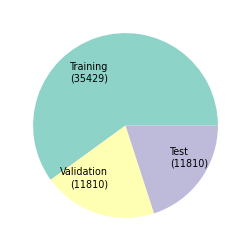

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.pie(
    [y_tr.size, y_v.size, y_te.size], 
    labels=[f"{kind}\n({num})" for kind, num in zip(["Training", "Validation", "Test"],  [y_tr.size, y_v.size, y_te.size])], 
    labeldistance=.6, textprops={'size': 'x-small'},
    colors=[plt.cm.Set3(i) for i in range(3)]
)

# if conf.savefig:
#     fig.savefig(f"{conf.out}/holdout{conf.suffix}", **kwarg_savefig)

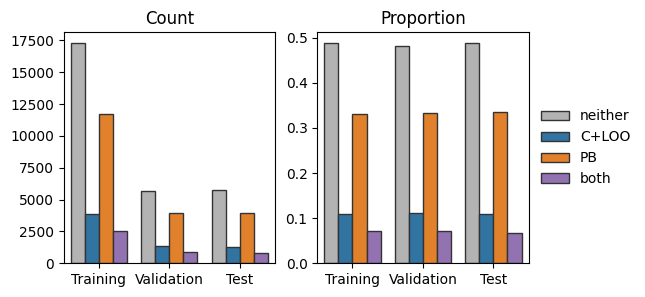

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

for i, (ds, a) in enumerate(zip([ds_tally, ds_tally_rate], ax.ravel())):
    sns.barplot(
        data=ds.reset_index(),
        x="dataset", y=0, hue="", ax=a, 
        palette=[".7", "C0", "C1", "C4"],
        edgecolor=".2"
    )
    a.set(xlabel="", ylabel="", title=["Count", "Proportion"][i])

ax[0].get_legend().remove()
ax[1].legend(loc="center left", bbox_to_anchor=(1, .5), frameon=False)

# if conf.savefig:
#     fig.savefig(f"{conf.out}/holdout_classbalance{conf.suffix}", **kwarg_savefig)

In [11]:
logger = {}

model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    # verbosity=-1,
    callbacks=[
        lgbm.early_stopping(100), 
        lgbm.log_evaluation(10000), 
        lgbm.record_evaluation(logger)
    ]
)

[I 2025-11-30 16:40:28,158] A new study created in memory with name: no-name-776a4b89-97e4-49b2-95a8-79229a9a6872


In [12]:
%%capture
model.run()

[I 2025-11-30 16:40:29,535] Trial 0 finished with value: 0.4144422185933408 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.4144422185933408.
[I 2025-11-30 16:40:30,130] Trial 1 finished with value: 0.4143373014728051 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.4143373014728051.
[I 2025-11-30 16:40:30,654] Trial 2 finished with value: 0.4145205580407149 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.4143373014728051.
[I 2025-11-30 16:40:31,142] Trial 3 finished with value: 0.41348545909791484 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.41348545909791484.
[I 2025-11-30 16:40:31,632] Trial 4 finished with value: 0.4164689757010462 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.41348545909791484.
[I 2025-11-30 16:40:32,250] Trial 5 finished with value: 0.4127998025008654 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 

In [13]:
tuned = model.get_best_booster()

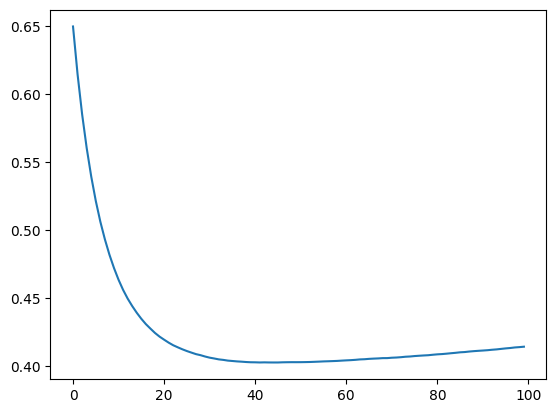

In [14]:
plt.plot(
    logger["valid_0"]["multi_logloss"]
    # logger["valid_0"]["l2"]
)

In [15]:
from sklearn.preprocessing import label_binarize

In [16]:
testx = x_te.loc[y_te.sort_values().index, :]
testy = y_te.sort_values()

In [17]:
label_bin = label_binarize(
    testy,
    classes = testy.unique()
)

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

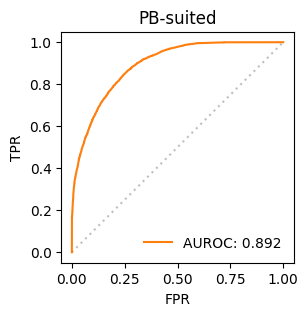

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))

x, y, thresh = roc_curve(testy, tuned.predict(testx)[:, 1])
auc = roc_auc_score(testy, tuned.predict(testx)[:, 1])

ax.plot(x, y, label=f"AUROC: {round(auc, 3)}", c="C1")
ax.plot([0, 1], [0, 1], c="gray", linestyle=(0, (1, 2)), zorder=1, alpha=0.5)
ax.legend(frameon=False)
ax.set(title="PB-suited", xlabel="FPR", ylabel="TPR")

if conf.savefig:
    fig.savefig(f"{conf.out}/auc{conf.suffix}.pdf", **kwarg_savefig)

(-0.05, 1.05)

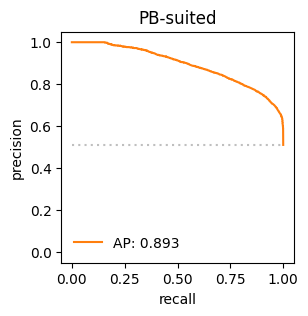

In [20]:
fig, ax = plt.subplots(figsize=(3, 3))

y, x, thresh = precision_recall_curve(testy, tuned.predict(testx)[:, 1])
ap = average_precision_score(testy, tuned.predict(testx)[:, 1])
base = testy.value_counts().cumsum()[0] / testy.value_counts().cumsum()[1]

ax.plot(x, y, label=f"AP: {round(ap, 3)}", c="C1")
ax.plot([0, 1], [base] * 2, c="gray", linestyle=(0, (1, 2)), zorder=1, alpha=0.5)
ax.legend(frameon=False)
ax.set(title="PB-suited", xlabel="recall", ylabel="precision")

ax.set_ylim(ax.get_xlim())

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pr{conf.suffix}", **kwarg_savefig)

In [21]:
from sklearn.metrics import confusion_matrix

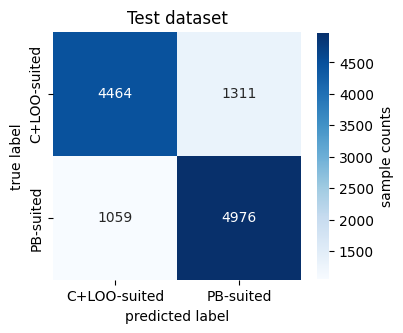

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    confusion_matrix(testy, tuned.predict(testx).argmax(axis=1)), 
    square=True, annot=True, fmt="", cmap="Blues",
    cbar_kws={"label": "sample counts", "shrink": .8}
)

ax.set_xticklabels(["C+LOO-suited", "PB-suited"])
ax.set_yticklabels(["C+LOO-suited", "PB-suited"])
ax.set(xlabel="predicted label", ylabel="true label", title="Test dataset");

# if conf.savefig:
#     fig.savefig(f"{conf.out}/confusion_matrix{conf.suffix}", **kwarg_savefig)

In [23]:
shap.initjs()

In [24]:
testx.columns = [feat_names_short[name] for name in df.columns]

In [25]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=testx)

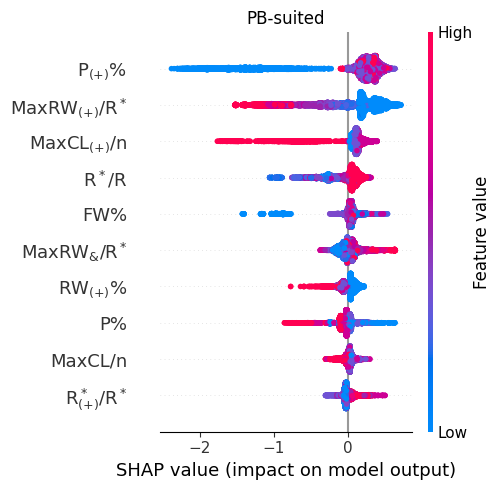

In [26]:
plt.axes(title="PB-suited")
shap.summary_plot(
    shap_values[:, :, -1], testx, 
    # max_display=df.shape[1], 
    max_display=10,
    show=False,
    plot_size=(5, 5)
)

if conf.savefig:
    plt.savefig(f"{conf.out}/shap_pb_is_better.pdf", **kwarg_savefig)

In [27]:
data

,cloo,pb,v,
0,0.000000,0.000000,0,neither
1,0.000000,0.000000,0,neither
2,0.000000,0.000000,0,neither
3,0.000000,0.000000,0,neither
4,0.000000,0.000000,0,neither
...,...,...,...,...
59044,0.750000,0.750000,3,both
59045,1.000000,0.750000,1,C+LOO
59046,0.333333,-0.333333,0,neither
59047,0.750000,0.750000,3,both


In [28]:
dat = pd.concat([data, df], axis=1).assign(
    better_with_pb=pd.DataFrame({"": data.pb > data.cloo})
)

In [29]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

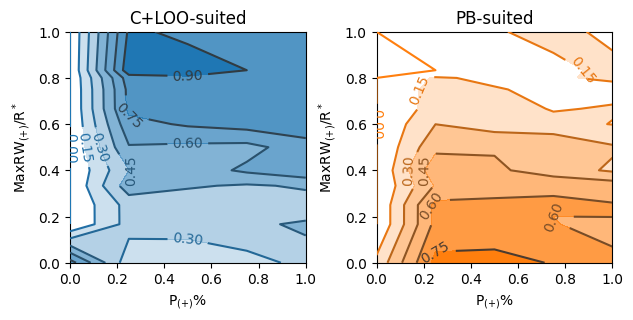

In [30]:
import matplotlib.colors as mcolors

keyx = "positive_pathway_coverage"
keyy = "max_positive_edge_density"

x1d = np.sort(dat.loc[:, keyx].unique())
y1d = np.sort(dat.loc[:, keyy].unique())
x2d, y2d = np.meshgrid(x1d, y1d)


def query_ratio(sorted_df, key):
    df_vals = sorted_df.value_counts() / sorted_df.size
    return df_vals[key] if key in df_vals.index else 0

df_ratios = pd.DataFrame({
    keyx: x2d.ravel(),
    keyy: y2d.ravel(),
    **{
        k: np.array([
            query_ratio(
                dat[(dat.loc[:, keyx] == x) & (dat.loc[:, keyy] == y)].better_with_pb,
                k
            ) for x, y in zip(x2d.ravel(), y2d.ravel())
        ]) for k in np.sort(dat.better_with_pb.unique())
    }
    
})

fig, ax = plt.subplots(
    1, 2, figsize=(7, 3), 
    # sharex=True, sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, a in enumerate(ax.ravel()):
    
    rgb = mcolors.to_rgb({0: "C0", 1: "C1"}[i])
    cmap_contour = mcolors.ListedColormap(
        [(r, g, b, 1) for r, g, b in zip(*[np.linspace(c, 0.2, 10) for c in rgb])]
    )
    
    a.contourf(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=mcolors.ListedColormap([(*rgb, alpha) for alpha in np.linspace(1.0, 0, 10)[::-1]])
    )
    contour = a.contour(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=cmap_contour, 
        zorder=100
    )
    contour.clabel(fmt=f'%.{2}f')
    a.set(
        title={i: v for i, v in enumerate(["C+LOO-suited", "PB-suited"])}[i],
        xlabel=feat_names_short[keyx], ylabel=feat_names_short[keyy]
    )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/contour_{keyy}_vs_{keyx}{conf.suffix}", **kwarg_savefig)

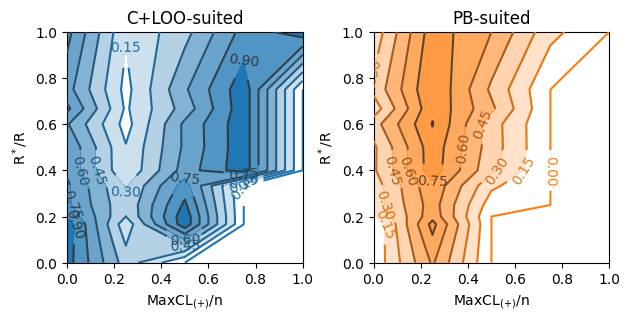

In [31]:
import matplotlib.colors as mcolors

keyx = "max_positive_cascade_length_ratio"
keyy = "edge_effectivity"

x1d = np.sort(dat.loc[:, keyx].unique())
y1d = np.sort(dat.loc[:, keyy].unique())
x2d, y2d = np.meshgrid(x1d, y1d)


def query_ratio(sorted_df, key):
    df_vals = sorted_df.value_counts() / sorted_df.size
    return df_vals[key] if key in df_vals.index else 0

df_ratios = pd.DataFrame({
    keyx: x2d.ravel(),
    keyy: y2d.ravel(),
    **{
        k: np.array([
            query_ratio(
                dat[(dat.loc[:, keyx] == x) & (dat.loc[:, keyy] == y)].better_with_pb,
                k
            ) for x, y in zip(x2d.ravel(), y2d.ravel())
        ]) for k in np.sort(dat.better_with_pb.unique())
    }
    
})

fig, ax = plt.subplots(
    1, 2, figsize=(7, 3), 
    # sharex=True, sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, a in enumerate(ax.ravel()):
    
    rgb = mcolors.to_rgb({0: "C0", 1: "C1"}[i])
    cmap_contour = mcolors.ListedColormap(
        [(r, g, b, 1) for r, g, b in zip(*[np.linspace(c, 0.2, 10) for c in rgb])]
    )
    
    a.contourf(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=mcolors.ListedColormap([(*rgb, alpha) for alpha in np.linspace(1.0, 0, 10)[::-1]])
    )
    contour = a.contour(
        x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        cmap=cmap_contour, 
        zorder=100
    )
    contour.clabel(fmt=f'%.{2}f')
    a.set(
        title={i: v for i, v in enumerate(["C+LOO-suited", "PB-suited"])}[i],
        xlabel=feat_names_short[keyx], ylabel=feat_names_short[keyy]
    )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/contour_{keyy}_vs_{keyx}{conf.suffix}", **kwarg_savefig)

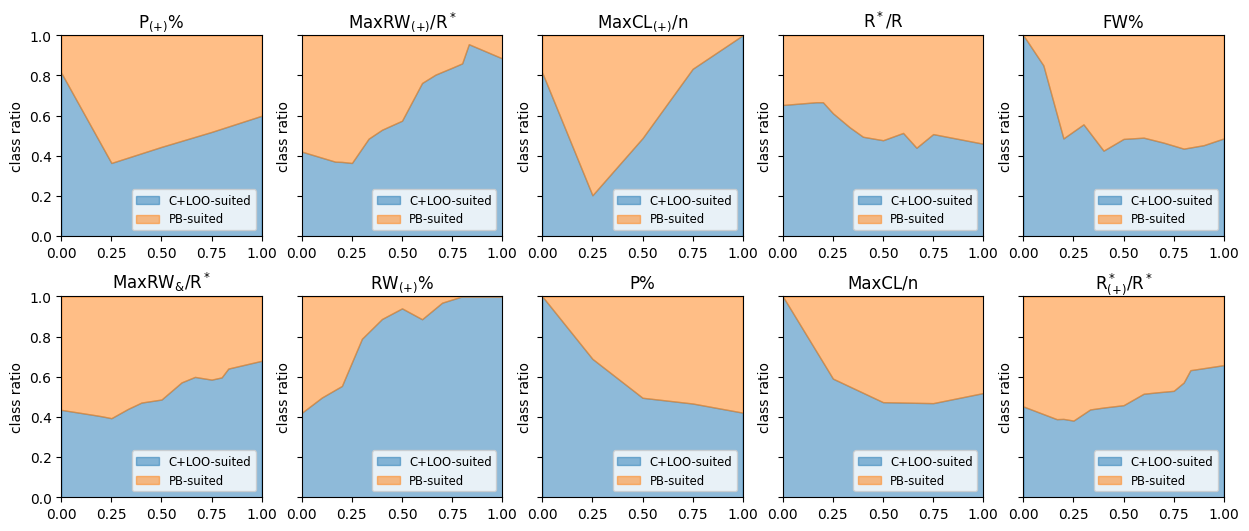

In [32]:
keys = np.array([
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "edge_effectivity",
    "mean_factor_density",
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "max_cascade_length_ratio",
    "effective_edge_positivity"
])

nrow = 2
ncol = np.ceil(keys.size / nrow).astype(int)

fig, ax = plt.subplots(
    nrow, ncol, 
    figsize=(3 * ncol, 3 * nrow), 
    sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for key, a in zip(keys, ax.ravel()):
    
    x = np.sort(dat.loc[:, key].unique())
    y_false = [query_ratio(dat[(dat.loc[:, key] == v)].better_with_pb, False) for v in np.sort(dat.loc[:, key].unique())]
    # a.plot(x, y_false, c="C0")
    # a.plot(x, np.ones(len(x)), c="C1")
    a.fill_between(x, np.zeros(len(x)), y_false, label="C+LOO-suited", alpha=.5, color="C0")
    a.fill_between(x, y_false, np.ones(len(x)), label="PB-suited", alpha=.5, color="C1")
    # sns.kdeplot(dat[key][dat.better_with_pb == True], ax=a, label="PB > C+LOO", fill=True)
    a.legend(loc="lower right", fontsize="small")
    a.set(title=feat_names_short[key], xlabel="", ylabel=f"class ratio", xlim=[0, 1], ylim=[0, 1])
    
# if conf.savefig:
#     fig.savefig(f"{conf.out}/top10_class_ratio{conf.suffix}", **kwarg_savefig)

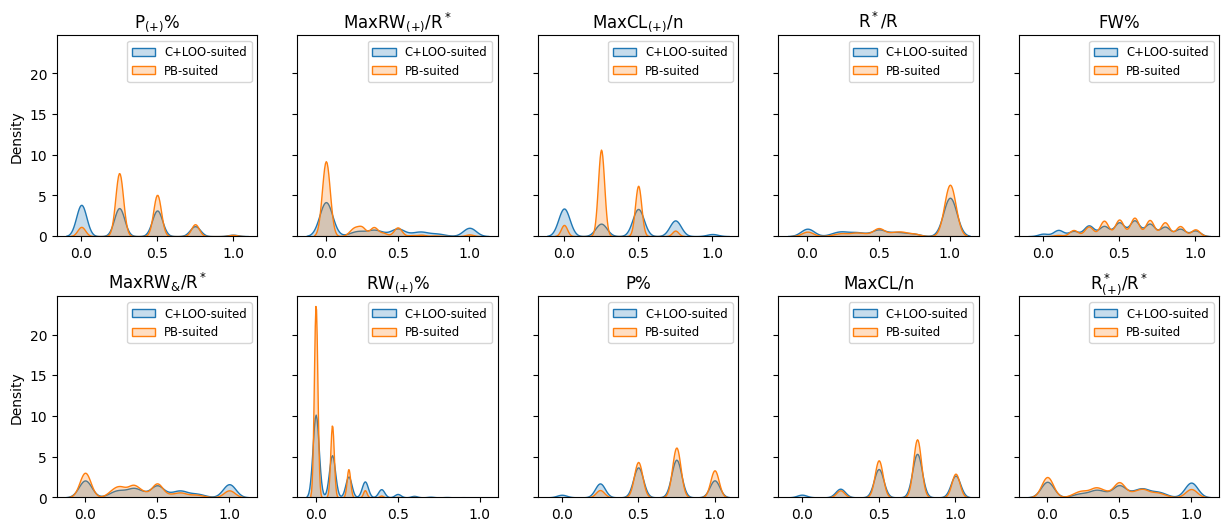

In [33]:
keys = np.array([
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "edge_effectivity",
    "mean_factor_density",
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "max_cascade_length_ratio",
    "effective_edge_positivity"
])

nrow = 2
ncol = np.ceil(keys.size / nrow).astype(int)

fig, ax = plt.subplots(
    nrow, ncol, 
    figsize=(3 * ncol, 3 * nrow), 
    sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for key, a in zip(keys, ax.ravel()):
    sns.kdeplot(dat[key][dat.better_with_pb == False], ax=a, label="C+LOO-suited", fill=True)
    sns.kdeplot(dat[key][dat.better_with_pb == True], ax=a, label="PB-suited", fill=True)
    a.legend(loc="upper right", fontsize="small")
    a.set(title=feat_names_short[key], xlabel="")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/top10_kde{conf.suffix}", **kwarg_savefig)

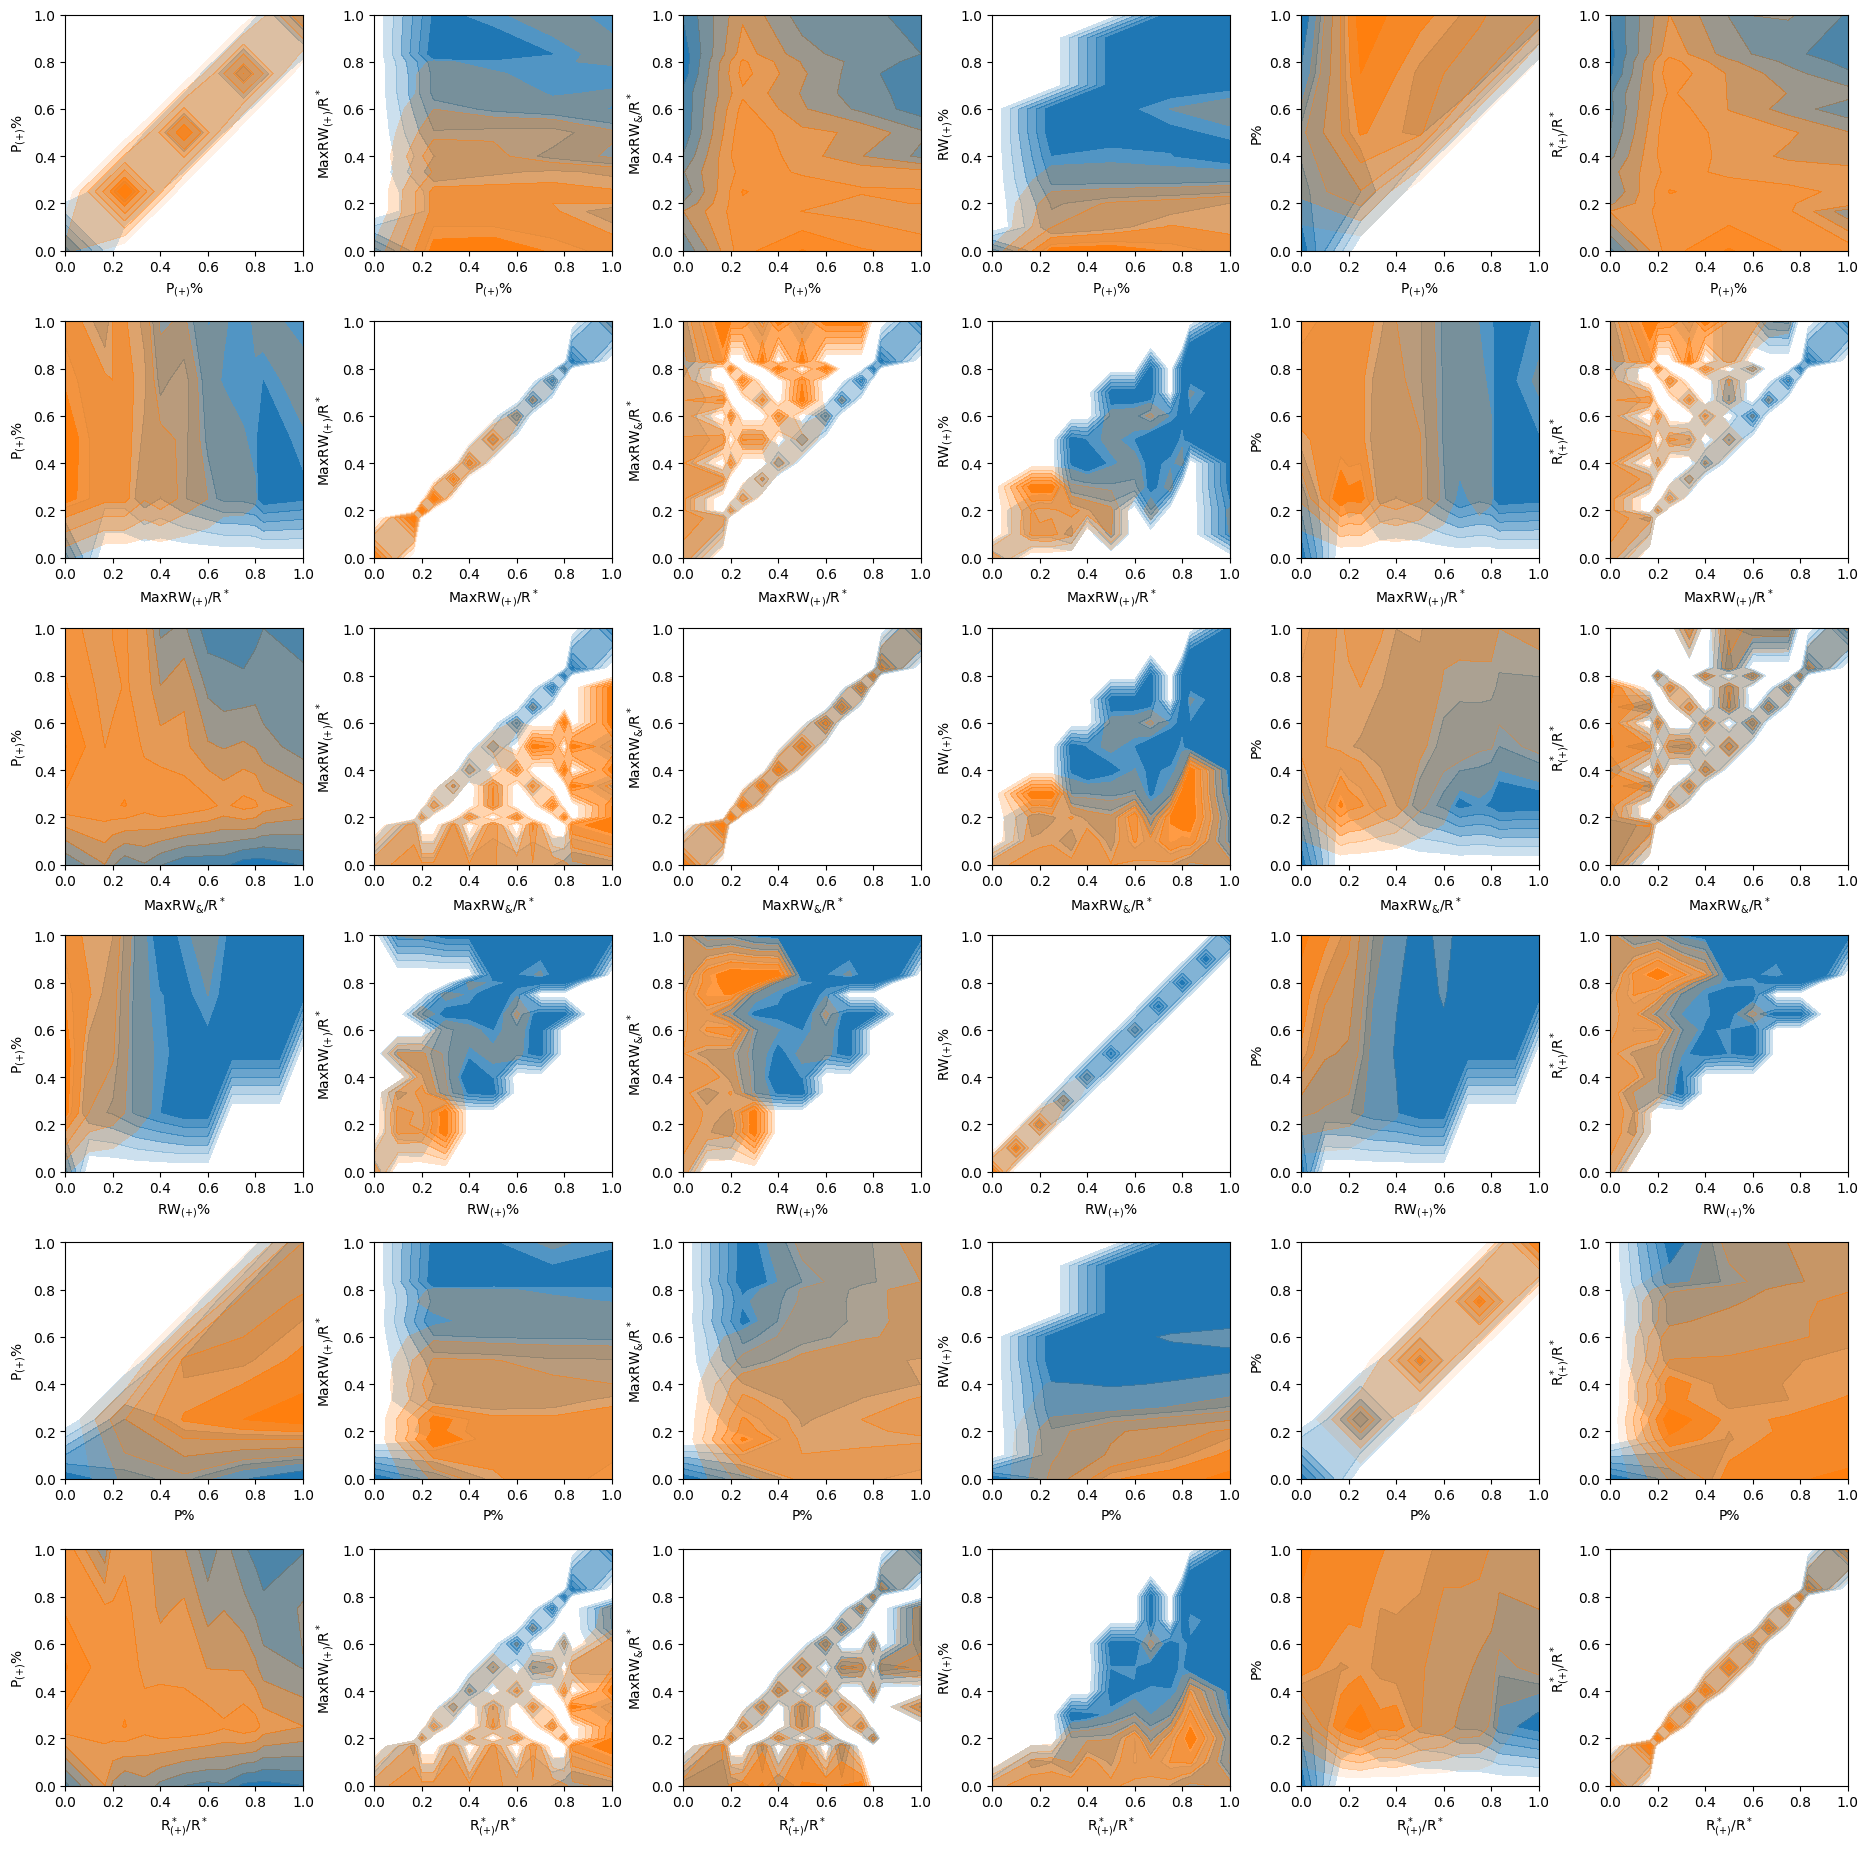

In [34]:
import matplotlib.colors as mcolors
from itertools import product

keys = np.array([
    "positive_pathway_coverage",
    "max_positive_edge_density", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "effective_edge_positivity"
])

def query_ratio(sorted_df, key):
        df_vals = sorted_df.value_counts() / sorted_df.size
        return df_vals[key] if key in df_vals.index else 0


fig, ax = plt.subplots(
    keys.size, keys.size, 
    figsize=(3 * keys.size + 1 * (keys.size - 1), 3 * keys.size + 1 * (keys.size - 1)), 
    # sharex=True, sharey=True
)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for (keyx, keyy), a in zip(product(keys, keys), ax.ravel()):

    x1d = np.sort(dat.loc[:, keyx].unique())
    y1d = np.sort(dat.loc[:, keyy].unique())
    x2d, y2d = np.meshgrid(x1d, y1d)

    df_ratios = pd.DataFrame({
        keyx: x2d.ravel(),
        keyy: y2d.ravel(),
        **{
            k: np.array([
                query_ratio(
                    dat[(dat.loc[:, keyx] == x) & (dat.loc[:, keyy] == y)].better_with_pb,
                    k
                ) for x, y in zip(x2d.ravel(), y2d.ravel())
            ]) for k in np.sort(dat.better_with_pb.unique())
        }

    })

    for i in range(2):
        rgb = mcolors.to_rgb({0: "C0", 1: "C1"}[i])
        cmap_contour = mcolors.ListedColormap(
            [(r, g, b, 1) for r, g, b in zip(*[np.linspace(c, 0.2, 10) for c in rgb])]
        )

        a.contourf(
            x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
            cmap=mcolors.ListedColormap([(*rgb, alpha) for alpha in np.linspace(1.0, 0, 10)[::-1]]),
            # label=["PB $\leq$ C+LOO", "PB > C+LOO"][i]
        )
        # contour = a.contour(
        #     x2d, y2d, df_ratios.loc[:, i].values.reshape(x2d.shape),
        #     cmap=cmap_contour, 
        #     zorder=100
        # )
        # contour.clabel(fmt=f'%.{2}f')
        a.set(
            # title={i: v for i, v in enumerate(["PB $\leq$ C+LOO", "PB > C+LOO"])}[i],
            xlabel=feat_names_short[keyx], ylabel=feat_names_short[keyy]
        )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/contour_key_features{conf.suffix}", **kwarg_savefig)